In [1]:
import os
import numpy as np
import pandas as pd
from Bio.PDB.Polypeptide import three_to_index
from Bio.PDB.Polypeptide import one_to_three

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = np.array([10,6.180])    #golden ratio
plt.rcParams['figure.facecolor'] = 'w'

In [3]:
def get_filtered_B_inv_lambda_and_P(filtered_lamb, cutoff_mode, P, method='extend_all_after_first_noisy_mode'):
    if method == 'zero_all_after_first_noisy_mode':
        filtered_lamb_inv = 1 / filtered_lamb
        # for "zeroing unreliable eigenvalues"
        filtered_lamb_inv[cutoff_mode:] = 0.0
        filtered_B_inv = np.dot(
            P, np.dot(np.diag(filtered_lamb_inv), np.linalg.inv(P)))
        filtered_lamb = 1 / filtered_lamb_inv
    if method == 'extend_all_after_first_noisy_mode':
        # for "extending lowest reliable eigenvalue"
        filtered_lamb[cutoff_mode:] = filtered_lamb[cutoff_mode - 1]
        filtered_B_inv = np.dot(
            P, np.dot(np.diag(1 / filtered_lamb), np.linalg.inv(P)))

    return filtered_B_inv, filtered_lamb, P


def sort_eigenvalues_and_eigenvectors(eigenvalues, eigenvectors):
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    return eigenvalues, eigenvectors


def get_A_B(pre, n=201, first_half=False, second_half=False,):
    # pre = "/Users/weilu/Research/server/aug_2020/curated_single_chain_optimization/optimization_msa_mode_3/gamma_mode_3"
    A = np.load(f"{pre}/average_A.npy", allow_pickle=True)
    B = np.load(f"{pre}/average_B.npy", allow_pickle=True)
    A_prime = np.load(f"{pre}/average_A_prime.npy", allow_pickle=True)
    # half_B = np.load(f"{pre}/average_half_B.npy", allow_pickle=True)
    # other_half_B = np.load(f"{pre}/average_other_half_B.npy", allow_pickle=True)
    # std_half_B = np.load(f"{pre}/average_std_half_B.npy", allow_pickle=True)
#     A = A[:n]
#     B = B[:n,:n]
#     A_prime = A_prime[:n]
#     half_B = half_B[:n,:n]
#     other_half_B = other_half_B[:n, :n]
#     std_half_B = std_half_B[:n, :n]
    if second_half:
        half_n = int(n/2)
        A = A[half_n:]
        B = B[half_n:,half_n:]
        A_prime = A_prime[half_n:]
        # half_B = half_B[half_n:,half_n:]
        # other_half_B = other_half_B[half_n:, half_n:]
        # std_half_B = std_half_B[half_n:, half_n:]
    A_B_dic = {}
    A_B_dic["A"] = A
    A_B_dic["B"] = B
    # A_B_dic["half_B"] = half_B
    # A_B_dic["other_half_B"] = other_half_B
    # A_B_dic["std_half_B"] = std_half_B
    A_B_dic["A_prime"] = A_prime
    return A_B_dic

def get_gamma(A, B, A_prime, c=-100, cutoff_range=range(100, 210, 10)):
    gamma_cutoff_dic = {}
    for cutoff in list(cutoff_range):
        # cutoff = 400
        lamb, P = np.linalg.eig(B)
        lamb, P = sort_eigenvalues_and_eigenvectors(lamb, P)
        filtered_lamb = np.copy(lamb)
        cutoff_mode = cutoff
        filtered_B_inv, filtered_lamb, P = get_filtered_B_inv_lambda_and_P(filtered_lamb,
                                                                           cutoff_mode, P)
        B_inv = filtered_B_inv
        lambda_2 = (A_prime.dot(B_inv).dot(A) - c) / (A_prime.dot(B_inv).dot(A_prime))
        gamma_new = B_inv.dot(A-A_prime*lambda_2)
        gamma_cutoff_dic[cutoff] = gamma_new
    return gamma_cutoff_dic

In [16]:
def compute_z(A_B, gamma, n=-1, start=0):
    if n == -1:
        n = A_B["A"].shape[0]
    # z score
    B = A_B["B"][start:start+n,start:start+n]
    A = A_B["A"][start:start+n]
    A_prime = A_B["A_prime"][start:start+n]
    x = gamma
    # x = gamma_mode15[520]
    e_std = (np.dot(x, B).dot(x))**0.5
    z = A.dot(x) / e_std
    print(z, e_std, A.dot(x), A_prime.dot(x))
    
def filter_B_matrix(B, cutoff):
    # cutoff = 520
    lamb, P = np.linalg.eig(B)
    lamb, P = sort_eigenvalues_and_eigenvectors(lamb, P)
    filtered_lamb = np.copy(lamb)
    cutoff_mode = cutoff
    filtered_B_inv, filtered_lamb, P = get_filtered_B_inv_lambda_and_P(filtered_lamb,
                                                                       cutoff_mode, P)
    B_new = np.linalg.inv(filtered_B_inv)
    return B_new

# Using the Helix Swapping method

## max swaping to 5

In [52]:
new_mode15_all_prime = np.loadtxt("/Users/weilu/Research/server/oct_2020/membrane_protein_structure_prediction/gamma_folder/new_mode15_all_prime.dat")

In [4]:
pre = "/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/optimization_msa_submode_20/gamma/"
mode_20 = get_A_B(pre, n=690)

In [5]:
A_B = mode_20
cutoff_range=list(range(400, 700, 20)) 
gamma_mode20 = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-60, cutoff_range=cutoff_range)

In [6]:
# z score
A_B = mode_20
B = A_B["B"]
A = A_B["A"]
A_prime = A_B["A_prime"]
# x = gamma_mode16[722]
x = gamma_mode20[600]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

1.4369138213720518 1.6152856771534818 2.321026314966152 -60.00000000000006


In [8]:
# z score
A_B = mode_20
B = A_B["B"]
A = A_B["A"]
A_prime = A_B["A_prime"]
# x = gamma_mode16[722]
x = gamma_mode20[680]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

1.4632294553291905 1.5881951109423176 2.3238938671406104 -60.0000000000001


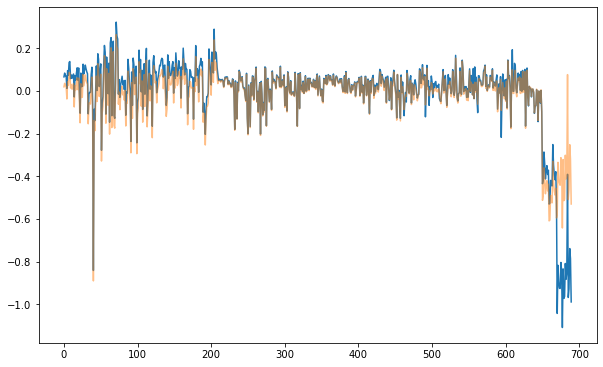

In [13]:
plt.plot(gamma_mode20[680])
plt.plot(gamma_mode20[600], alpha=0.5)

In [14]:
B = mode_20['B']
cutoff = 600
lamb, P = np.linalg.eig(B)
lamb, P = sort_eigenvalues_and_eigenvectors(lamb, P)
filtered_lamb = np.copy(lamb)
cutoff_mode = cutoff
filtered_B_inv, filtered_lamb, P = get_filtered_B_inv_lambda_and_P(filtered_lamb,
                                                                   cutoff_mode, P)
B_new = np.linalg.inv(filtered_B_inv)

In [15]:
abFile = "/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/optimization_msa_submode_20/a_prime_all.npy"
a_prime_all_mode20 = np.load(abFile, allow_pickle=True)
abFile = "/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/optimization_msa_submode_20/a_all.npy"
a_all_mode20 = np.load(abFile, allow_pickle=True)

In [49]:
from cvxopt import matrix, solvers
A_B = mode_20
# B = A_B['B']
B = B_new
A = A_B['A']
A_prime = A_B['A_prime']
n = len(A_prime)

Q = 2*matrix(B)
p = matrix(np.zeros(n))
# G = matrix(-A, (1,n))
# h = matrix(-7.117566, (1, 1), 'd')
# additional_constraint = np.diag([-1]*n)
# additional_constraint = A_B_6nq0_A['A_prime'].reshape(1,n)
additional_constraint = a_prime_all_mode20
# additional_constraint = -a_all_mode18
# G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n), additional_constraint]), (2+n,n))
# h = matrix([-21, -0]+[15]*n, (2+n, 1), 'd')
# G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n), additional_constraint]), (2+1,n))
# h = matrix([-21, -0]+[-0], (2+1, 1), 'd')
n_additional_constraint = additional_constraint.shape[0]
G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n), additional_constraint]), (2+n_additional_constraint,n))
h = matrix([-5, -50]+[-0]*n_additional_constraint, (2+n_additional_constraint, 1), 'd')
sol=solvers.qp(Q, p, G=G, h=h)
x = np.array(sol['x']).flatten()

     pcost       dcost       gap    pres   dres
 0:  4.0396e-01  2.5173e+03  6e+04  3e+01  9e+04
 1:  9.5791e+00 -1.3433e+04  5e+04  2e+01  6e+04
 2:  1.0458e+02 -8.0548e+03  9e+03  4e+00  1e+04
 3:  2.7319e+01 -9.8799e+02  1e+03  4e-01  1e+03
 4:  1.2759e+01 -8.0108e+01  9e+01  4e-02  1e+02
 5:  1.1372e+01  4.0086e+00  7e+00  3e-03  7e+00
 6:  1.1077e+01  1.0442e+01  6e-01  2e-05  6e-02
 7:  1.1023e+01  1.0601e+01  4e-01  1e-05  3e-02
 8:  1.1031e+01  1.0813e+01  2e-01  4e-14  8e-12
 9:  1.1024e+01  1.1013e+01  1e-02  4e-14  2e-12
10:  1.1021e+01  1.1021e+01  1e-04  4e-14  2e-11
11:  1.1021e+01  1.1021e+01  1e-06  4e-14  3e-10
Optimal solution found.


In [88]:
compute_z(mode_20, x)

1.5101098121750935 3.311017490207427 5.0000000002455876 -50.000031701926936


In [75]:
compute_z(mode_20, new_mode15_all_prime)

1.2348038863357502 5.265863960387635 6.502309283202017 -81.67709844922514


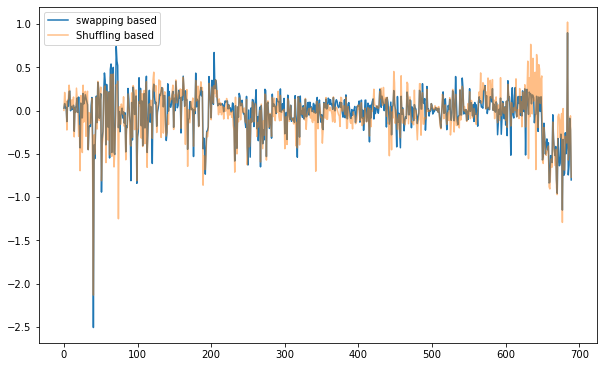

In [87]:
plt.plot(1.3*x, label="swapping based")
plt.plot(new_mode15_all_prime, alpha=0.5, label="Shuffling based")
plt.legend()

In [54]:
np.savetxt("/Users/weilu/Research/server/oct_2020/membrane_protein_structure_prediction/gamma_folder/mode20_decoy50_A5.dat", x)

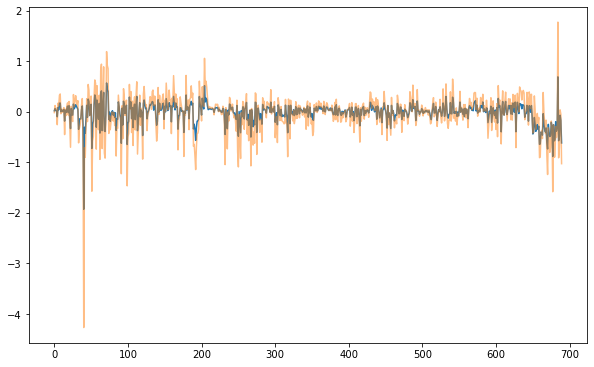

In [42]:
plt.plot(x)
# plt.plot(gamma_mode20[600], alpha=0.5)
plt.plot(mode20_decoy50, alpha=0.5)

In [30]:
mode20_decoy50 = np.loadtxt("/Users/weilu/Research/server/oct_2020/membrane_protein_structure_prediction/gamma_folder/mode20_decoy50.dat")

In [239]:
x = np.loadtxt("/Users/weilu/opt/parameters/original_membrane_gamma")

In [240]:
# z score
A_B = mode_20
B = A_B["B"]
A = A_B["A"]
A_prime = A_B["A_prime"]
# x = gamma_mode16[722]
# x = gamma_mode20[600]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

0.4147311331317683 10.0790489399915 4.180095387773223 -215.44066219737485


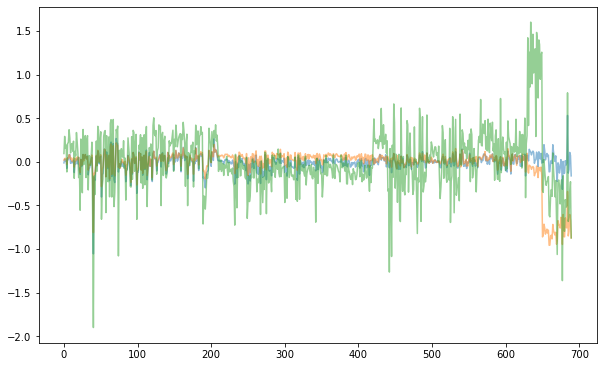

In [243]:
plt.plot(gamma_mode18[600][:690], alpha=0.5)
plt.plot(gamma_mode20[600][:690], alpha=0.5)
plt.plot(gamma_mode15[600][:690], alpha=0.5)
# plt.plot(gamma_mode16[722][:690], alpha=0.5)

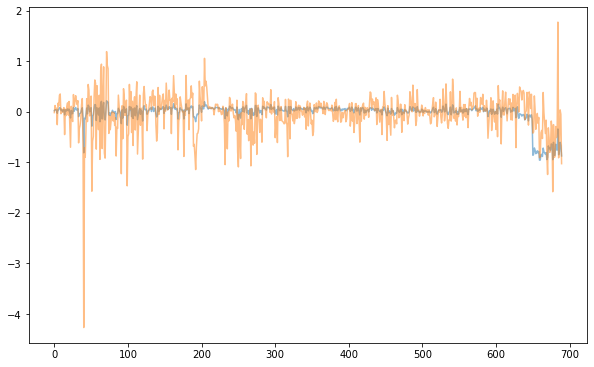

In [255]:
plt.plot(gamma_mode20[600][:690], alpha=0.5)
plt.plot(x, alpha=0.5)

In [256]:
# z score
A_B = mode_20
B = A_B["B"]
A = A_B["A"]
A_prime = A_B["A_prime"]
# x = gamma_mode16[722]
# x = gamma_mode20[600]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

1.3832367889441166 7.229420212019691 10.000000000001812 -50.00000202942445


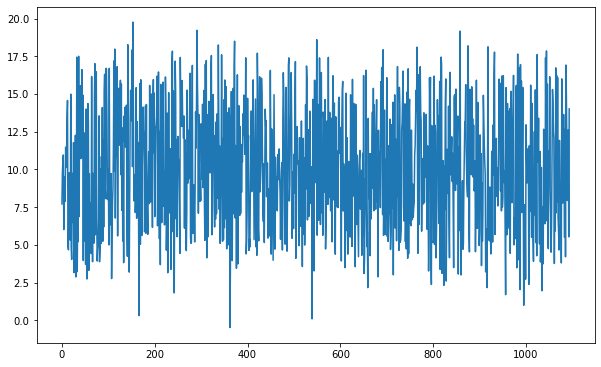

In [257]:
e_decoys = a_all_mode20.dot(x)
plt.plot(e_decoys)

In [ ]:
e_decoys = a_all_mode20.dot(x)
plt.plot(e_decoys)

In [258]:
np.savetxt("/Users/weilu/Research/server/oct_2020/membrane_protein_structure_prediction/gamma_folder/mode20_decoy50.dat", x)

## with four body term

In [142]:
pre = "/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/optimization_msa_submode_19/gamma/"
mode_19 = get_A_B(pre, n=2022)

In [143]:
A_B = mode_19
cutoff_range=list(range(522, 2122, 100)) 
gamma_mode19 = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-0, cutoff_range=cutoff_range)

In [144]:
# z score
B = A_B["B"]
A = A_B["A"]
A_prime = A_B["A_prime"]
# x = gamma_mode16[722]
x = gamma_mode19[722]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

1.7952686649207632 1.7255169560688408 3.097766522019847 -4.1639380745500665e-14


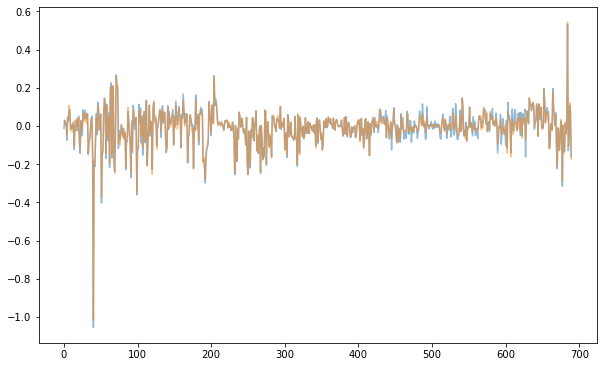

In [146]:
plt.plot(gamma_mode18[600][:690], alpha=0.5)
plt.plot(gamma_mode19[722][:690], alpha=0.5)
# plt.plot(gamma_mode16[722][:690], alpha=0.5)

In [154]:
# z score
A_B = mode_19
B = A_B["B"][:690,:690]
A = A_B["A"][:690]
A_prime = A_B["A_prime"][:690]
# x = gamma_mode16[722]
# x = gamma_mode18[600]
x = gamma_mode19[722][:690]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

1.555612371954856 1.480976308964884 2.303825068797811 -0.31545550522174765


## multi swapping

In [127]:
pre = "/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/optimization_msa_submode_18/gamma/"
mode_18 = get_A_B(pre, n=690)

In [128]:
A_B = mode_18
cutoff_range=list(range(400, 700, 20)) 
gamma_mode18 = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-0, cutoff_range=cutoff_range)

In [200]:
# z score
A_B = mode_18
B = A_B["B"]
A = A_B["A"]
A_prime = A_B["A_prime"]
# x = gamma_mode16[722]
x = gamma_mode18[600]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

1.6023974535297358 1.6017464202657083 2.566634385034141 2.4313884239290928e-14


In [136]:
A_B = mode_15
# z score
B = A_B["B"]
A = A_B["A"]
A_prime = A_B["A_prime"]
# x = gamma_mode16[722]
x = gamma_mode18[600]
# x = gamma_mode17[600]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

3.3666541002619708 1.6024120120471539 5.394766970667585 2.879431372056806


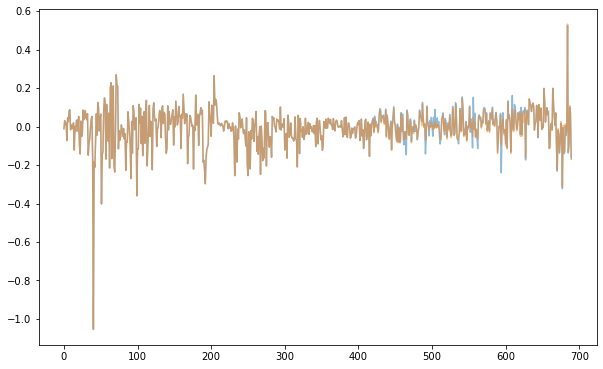

In [180]:
plt.plot(gamma_mode18[680][:690], alpha=0.5)
plt.plot(gamma_mode18[600][:690], alpha=0.5)

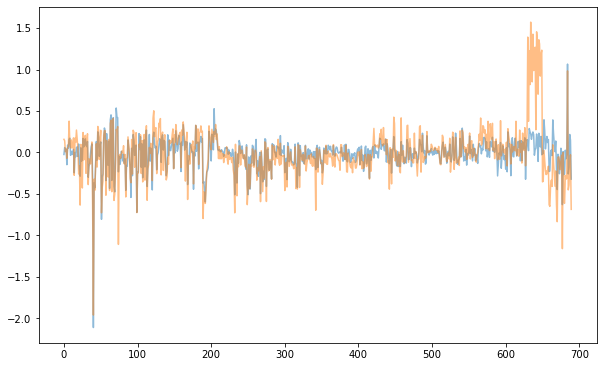

In [206]:
plt.plot(2*gamma_mode18[600][:690], alpha=0.5)
# plt.plot(2*gamma_mode17[600][:690], alpha=0.5)
plt.plot(gamma_mode16[722][:690], alpha=0.5)

In [156]:
abFile = "/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/optimization_msa_submode_18/a_prime_all.npy"
a_prime_all_mode18 = np.load(abFile, allow_pickle=True)
abFile = "/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/optimization_msa_submode_18/a_all.npy"
a_all_mode18 = np.load(abFile, allow_pickle=True)

In [181]:
B = mode_18['B']
cutoff = 600
lamb, P = np.linalg.eig(B)
lamb, P = sort_eigenvalues_and_eigenvectors(lamb, P)
filtered_lamb = np.copy(lamb)
cutoff_mode = cutoff
filtered_B_inv, filtered_lamb, P = get_filtered_B_inv_lambda_and_P(filtered_lamb,
                                                                   cutoff_mode, P)
B_new = np.linalg.inv(filtered_B_inv)

In [207]:
from cvxopt import matrix, solvers
A_B = mode_18
# B = A_B['B']
B = B_new
A = A_B['A']
A_prime = A_B['A_prime']
n = len(A_prime)

Q = 2*matrix(B)
p = matrix(np.zeros(n))
# G = matrix(-A, (1,n))
# h = matrix(-7.117566, (1, 1), 'd')
# additional_constraint = np.diag([-1]*n)
# additional_constraint = A_B_6nq0_A['A_prime'].reshape(1,n)
additional_constraint = a_prime_all_mode18
# additional_constraint = -a_all_mode18
# G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n), additional_constraint]), (2+n,n))
# h = matrix([-21, -0]+[15]*n, (2+n, 1), 'd')
# G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n), additional_constraint]), (2+1,n))
# h = matrix([-21, -0]+[-0], (2+1, 1), 'd')
n_additional_constraint = additional_constraint.shape[0]
G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n), additional_constraint]), (2+n_additional_constraint,n))
h = matrix([-2.57, -0]+[-0]*n_additional_constraint, (2+n_additional_constraint, 1), 'd')
sol=solvers.qp(Q, p, G=G, h=h)
x = np.array(sol['x']).flatten()

     pcost       dcost       gap    pres   dres
 0:  7.6950e-02  9.0717e+00  4e+03  5e+01  9e+04
 1:  1.3418e+01 -8.4706e+02  1e+03  1e+01  2e+04
 2:  8.0611e+00 -1.4474e+02  2e+02  1e+00  3e+03
 3:  4.3865e+00 -3.4904e+01  4e+01  3e-01  6e+02
 4:  2.9660e+00 -1.0867e+01  1e+01  1e-01  2e+02
 5:  2.6303e+00  1.0500e+00  2e+00  1e-02  2e+01
 6:  2.5980e+00  2.2898e+00  3e-01  2e-03  3e+00
 7:  2.5865e+00  2.5246e+00  6e-02  3e-04  6e-01
 8:  2.5864e+00  2.5471e+00  4e-02  2e-04  3e-01
 9:  2.5843e+00  2.5769e+00  7e-03  3e-05  5e-02
10:  2.5841e+00  2.5839e+00  2e-04  2e-07  5e-04
11:  2.5841e+00  2.5841e+00  2e-06  2e-09  5e-06
12:  2.5841e+00  2.5841e+00  2e-08  2e-11  5e-08
Optimal solution found.


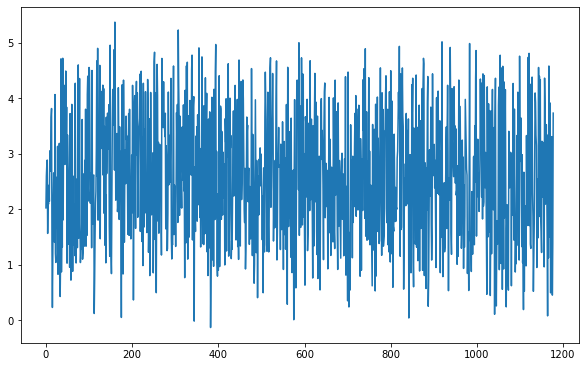

In [208]:
e_decoys = a_all_mode18.dot(x)
plt.plot(e_decoys)

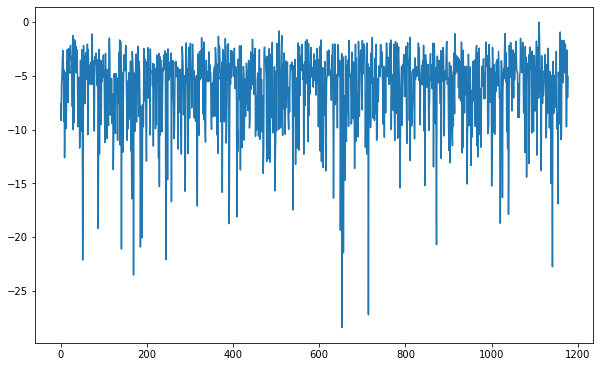

In [211]:
e_decoys = a_prime_all_mode18.dot(x)
plt.plot(e_decoys)

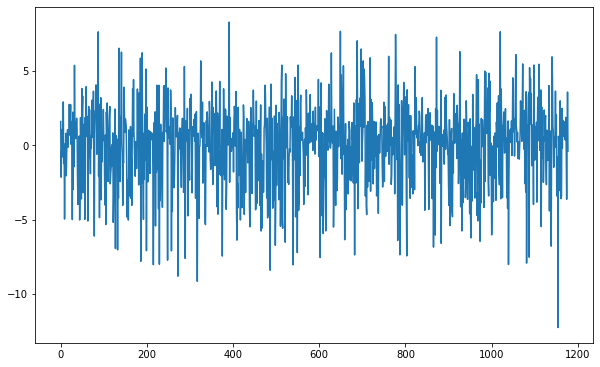

In [213]:
e_decoys = a_prime_all_mode18.dot(gamma_mode18[600])
plt.plot(e_decoys)

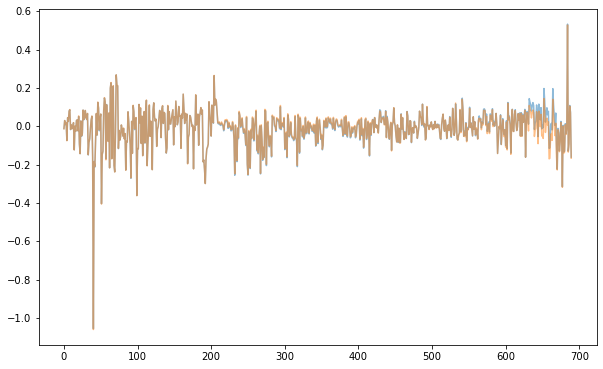

In [209]:
plt.plot(gamma_mode18[600][:690], alpha=0.5)
plt.plot(x, alpha=0.5)

In [214]:
# z score
A_B = mode_18
B = A_B["B"]
A = A_B["A"]
A_prime = A_B["A_prime"]
# x = gamma_mode16[722]
# x = gamma_mode18[600]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

1.59911593104235 1.6071380130330029 2.5700000000248227 -6.116724433643385


In [215]:
np.savetxt("/Users/weilu/Research/server/oct_2020/membrane_protein_structure_prediction/gamma_folder/mode18.dat", 2*x)

## single swap

In [55]:
pre = "/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/optimization_msa_submode_17/gamma/"
mode_17 = get_A_B(pre, n=690)

In [72]:
A_B = mode_17
cutoff_range=list(range(400, 700, 20)) 
gamma_mode17 = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-10, cutoff_range=cutoff_range)

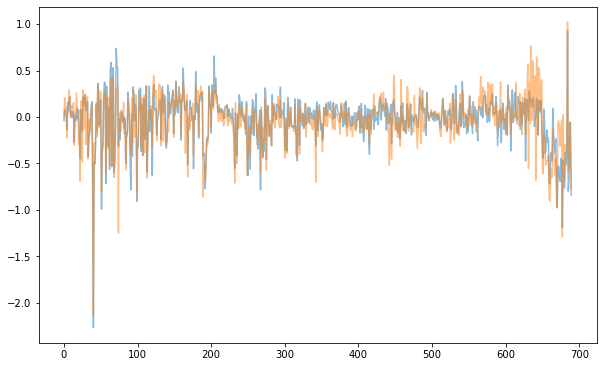

In [73]:
plt.plot(5* gamma_mode17[620][:690], alpha=0.5)
plt.plot(new_mode15_all_prime, alpha=0.5)
# plt.plot(gamma_mode15[520][:690])

In [74]:
compute_z(mode_17, 5*gamma_mode17[620])

0.7888812485638592 4.001208329294981 3.1564782225783374 -50.00000000000006


In [62]:
compute_z(mode_17, new_mode15_all_prime)

0.6180965338605059 4.801149581889427 2.967573915111672 -84.35802743072585


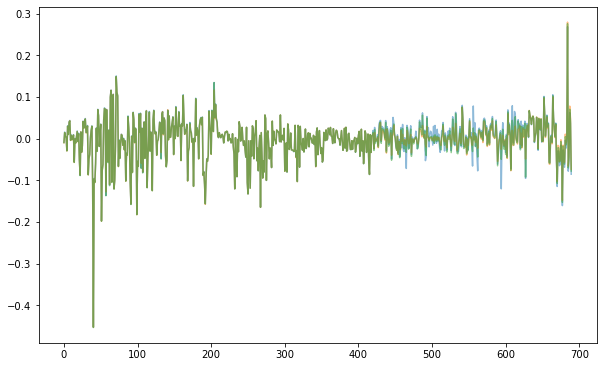

In [109]:
plt.plot(gamma_mode17[680][:690], alpha=0.5)
plt.plot(gamma_mode17[520][:690], alpha=0.5)
plt.plot(gamma_mode17[600][:690], alpha=0.5)

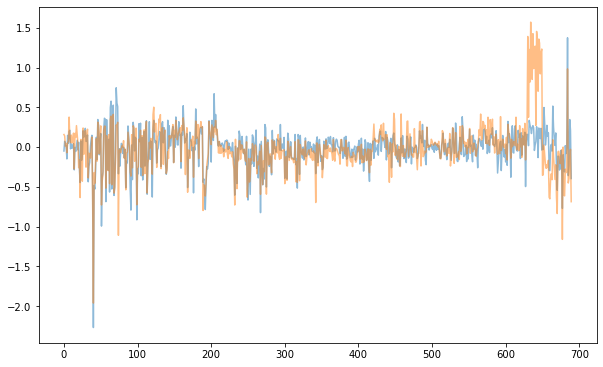

In [107]:
plt.plot(5* gamma_mode17[620][:690], alpha=0.5)
plt.plot(gamma_mode16[722][:690], alpha=0.5)
# plt.plot(gamma_mode15[520][:690])

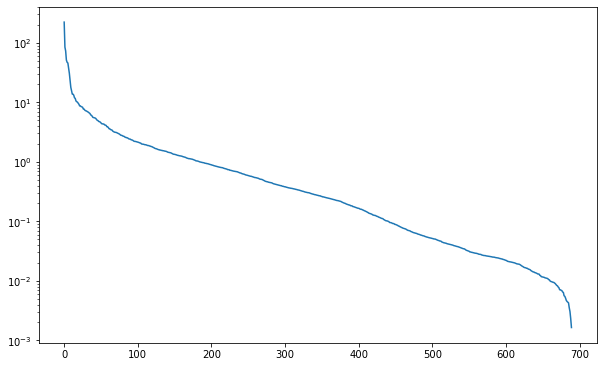

In [108]:
B = A_B['B']
lamb, P = np.linalg.eig(B)
lamb, P = sort_eigenvalues_and_eigenvectors(lamb, P)
plt.plot(lamb)
plt.yscale("log")

In [105]:
# z score
B = A_B["B"]
A = A_B["A"]
A_prime = A_B["A_prime"]
# x = gamma_mode16[722]
x = gamma_mode17[520]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

0.7951810888197598 0.7940091516131166 0.6313810617125718 3.0531133177191805e-15


In [106]:
# z score
B = A_B["B"]
A = A_B["A"]
A_prime = A_B["A_prime"]
# x = gamma_mode16[722]
x = gamma_mode17[680]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

0.795753389886715 0.7957250352781431 0.6332008942403082 2.7255975254547593e-14


In [111]:
B = mode_17['B']
cutoff = 600
lamb, P = np.linalg.eig(B)
lamb, P = sort_eigenvalues_and_eigenvectors(lamb, P)
filtered_lamb = np.copy(lamb)
cutoff_mode = cutoff
filtered_B_inv, filtered_lamb, P = get_filtered_B_inv_lambda_and_P(filtered_lamb,
                                                                   cutoff_mode, P)
B_new = np.linalg.inv(filtered_B_inv)

In [124]:
from cvxopt import matrix, solvers
A_B = mode_17
# B = A_B['B']
B = B_new
A = A_B['A']
A_prime = A_B['A_prime']
n = len(A_prime)

Q = 2*matrix(B)
p = matrix(np.zeros(n))

n_additional_constraint = additional_constraint.shape[0]
G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n)]), (2,n))
h = matrix([-3, -0], (2, 1), 'd')
sol=solvers.qp(Q, p, G=G, h=h)
x = np.array(sol['x']).flatten()

     pcost       dcost       gap    pres   dres
 0:  8.2154e-01  6.0156e+00  2e+00  2e+00  1e-13
 1:  6.0180e+00  1.2486e+01  3e+00  7e-01  5e-14
 2:  1.7155e+01  1.1906e+01  5e+00  9e-15  2e-13
 3:  1.4642e+01  1.3917e+01  7e-01  1e-14  2e-13
 4:  1.4293e+01  1.4189e+01  1e-01  3e-15  6e-13
 5:  1.4236e+01  1.4222e+01  1e-02  2e-15  1e-12
 6:  1.4227e+01  1.4225e+01  1e-03  1e-15  3e-12
 7:  1.4225e+01  1.4225e+01  3e-05  3e-15  7e-12
 8:  1.4225e+01  1.4225e+01  3e-07  2e-15  2e-11
Optimal solution found.


In [125]:
# z score
B = A_B["B"]
A = A_B["A"]
A_prime = A_B["A_prime"]
# x = gamma_mode16[722]
# x = gamma_mode17[680]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

0.7955802160094607 3.7708328340043202 3.000000000612724 -0.00017400906743603173


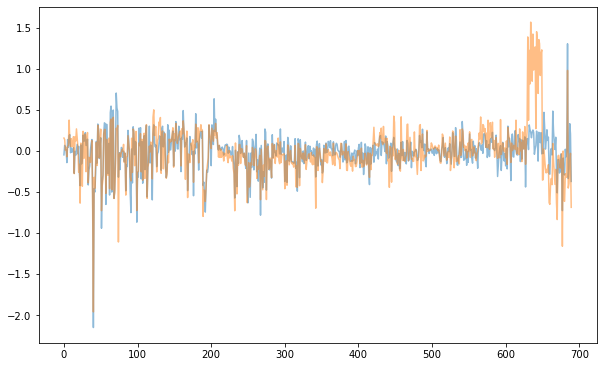

In [126]:
plt.plot(x, alpha=0.5)
# plt.plot(gamma_mode17[620][:690], alpha=0.5)
plt.plot(gamma_mode16[722][:690], alpha=0.5)
# plt.plot(gamma_mode15[520][:690])

In [84]:
pre = "/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/optimization_msa_submode_16/gamma/"
mode_16 = get_A_B(pre, n=2022)

In [85]:
abFile = "/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/optimization_msa_submode_16/a_prime_all.npy"
a_prime_all_mode16 = np.load(abFile, allow_pickle=True)

In [86]:
A_B = mode_16
cutoff_range=list(range(522, 2122, 100)) 
gamma_mode16 = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-0, cutoff_range=cutoff_range)

In [87]:
# z score
B = A_B["B"]
A = A_B["A"]
A_prime = A_B["A_prime"]
x = gamma_mode16[722]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

5.006197747326388 4.816455992909468 24.11213114180006 2.372545519421787e-13


In [88]:
B = mode_16['B']
cutoff = 722
lamb, P = np.linalg.eig(B)
lamb, P = sort_eigenvalues_and_eigenvectors(lamb, P)
filtered_lamb = np.copy(lamb)
cutoff_mode = cutoff
filtered_B_inv, filtered_lamb, P = get_filtered_B_inv_lambda_and_P(filtered_lamb,
                                                                   cutoff_mode, P)
B_new = np.linalg.inv(filtered_B_inv)

In [89]:
from cvxopt import matrix, solvers
A_B = mode_16
# B = A_B['B']
B = B_new
A = A_B['A']
A_prime = A_B['A_prime']
n = len(A_prime)

Q = 2*matrix(B)
p = matrix(np.zeros(n))
# G = matrix(-A, (1,n))
# h = matrix(-7.117566, (1, 1), 'd')
# additional_constraint = np.diag([-1]*n)
# additional_constraint = A_B_6nq0_A['A_prime'].reshape(1,n)
additional_constraint = a_prime_all_mode16
# G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n), additional_constraint]), (2+n,n))
# h = matrix([-21, -0]+[15]*n, (2+n, 1), 'd')
# G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n), additional_constraint]), (2+1,n))
# h = matrix([-21, -0]+[-0], (2+1, 1), 'd')
n_additional_constraint = additional_constraint.shape[0]
G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n), additional_constraint]), (2+n_additional_constraint,n))
h = matrix([-24, -0]+[-0]*n_additional_constraint, (2+n_additional_constraint, 1), 'd')
sol=solvers.qp(Q, p, G=G, h=h)
x = np.array(sol['x']).flatten()

     pcost       dcost       gap    pres   dres
 0:  3.5573e+01  1.0641e+02  2e+04  9e+00  2e+05
 1:  5.7300e+01 -1.9653e+03  2e+03  1e+00  2e+04
 2:  3.7141e+01 -3.5934e+02  4e+02  2e-01  4e+03
 3:  2.9939e+01 -3.9933e+01  7e+01  3e-02  6e+02
 4:  2.8326e+01  8.7680e+00  2e+01  9e-03  2e+02
 5:  2.7709e+01  2.1487e+01  6e+00  3e-03  5e+01
 6:  2.7232e+01  2.4614e+01  3e+00  1e-03  2e+01
 7:  2.7092e+01  2.4531e+01  3e+00  9e-04  1e+01
 8:  2.6691e+01  2.5796e+01  9e-01  4e-04  6e+00
 9:  2.6484e+01  2.5529e+01  1e+00  3e-04  5e+00
10:  2.6186e+01  2.5126e+01  1e+00  2e-04  4e+00
11:  2.5842e+01  2.5154e+01  7e-01  8e-05  1e+00
12:  2.5796e+01  2.5768e+01  3e-02  4e-06  7e-02
13:  2.5795e+01  2.5795e+01  3e-04  4e-08  7e-04
14:  2.5795e+01  2.5795e+01  3e-06  4e-10  7e-06
15:  2.5795e+01  2.5795e+01  3e-08  4e-12  7e-08
Optimal solution found.


In [93]:
toLocation = "/Users/weilu/Research/server/oct_2020/membrane_protein_structure_prediction/gamma_folder"
np.savetxt(f"{toLocation}/complete_cutoff722_contact_part_all_prime_oct14.dat", x[:690])
np.savetxt(f"{toLocation}/complete_cutoff722_fourBody_part_all_prime_oct14.dat", -x[690:])
np.savetxt(f"{toLocation}/complete_cutoff722_all_part_all_prime_oct14.dat", x)

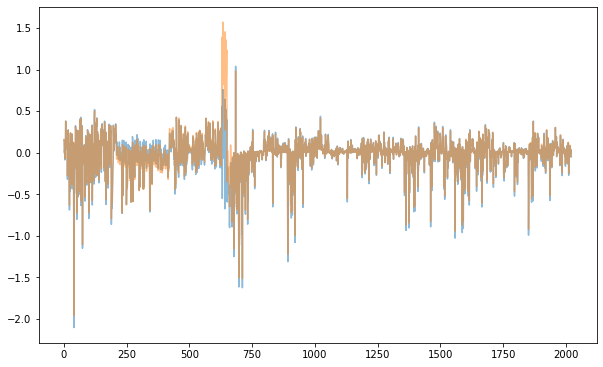

In [92]:
plt.plot(x, alpha=0.5)
plt.plot(gamma_mode16[722], alpha=0.5)

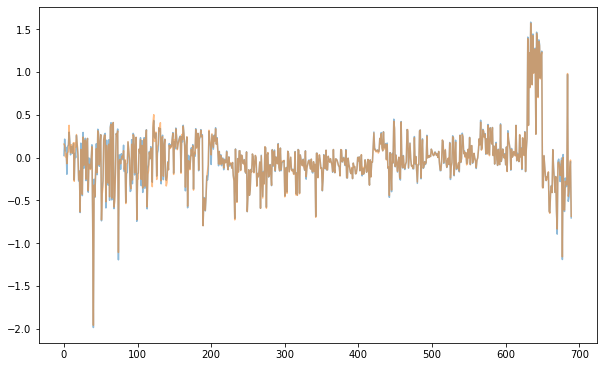

In [90]:
plt.plot(gamma_mode15[520][:690], alpha=0.5)
plt.plot(gamma_mode16[722][:690], alpha=0.5)

In [269]:
data = pd.read_csv("/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/optimization_msa_submode_15/z_scores.csv")

In [271]:
data.sort_values("Z")

,Unnamed: 0,Protein,E_native,E_decoy,E_diff,E_std,Z
73,73,2qfi_A,-28.017533,-2.461019e+01,3.407342,3.637535,0.936717
290,290,2lck_A,-5.009790,-8.322852e-09,5.009790,4.431393,1.130523
714,714,2gfp_A,-102.543241,-9.575537e+01,6.787866,5.991653,1.132887
451,451,6vja_D,-26.735181,-2.346513e+01,3.270056,2.781441,1.175670
583,583,2mgy_A,-38.204362,-3.444577e+01,3.758590,2.986710,1.258438
...,...,...,...,...,...,...,...
266,266,3rce_A,-145.930551,-1.015969e+02,44.333637,5.645482,7.852940
191,191,6kzo_A,-224.012710,-1.599975e+02,64.015227,8.140501,7.863794
167,167,5xti_j,-194.259449,-1.380684e+02,56.191035,6.829266,8.227976
51,51,6kzp_A,-240.179971,-1.709118e+02,69.268162,8.151418,8.497682


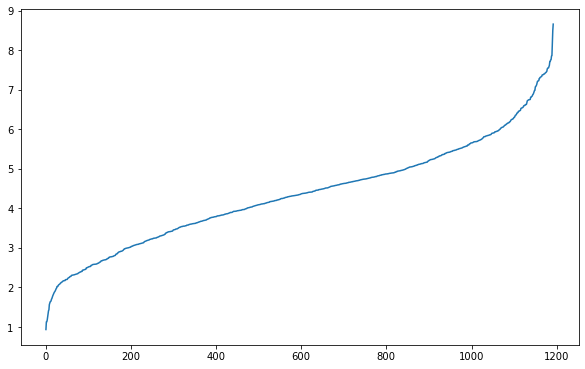

In [274]:
plt.plot(data.sort_values("Z").reset_index()["Z"])

## mode 15 repeats mode 9 (contact term only), but with bug-fixed

In [13]:
pre = "/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/optimization_msa_submode_15/gamma/"
mode_15 = get_A_B(pre, n=690)

In [14]:
A_B = mode_15
cutoff_range=list(range(400, 700, 20)) 
gamma_mode15 = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-0, cutoff_range=cutoff_range)

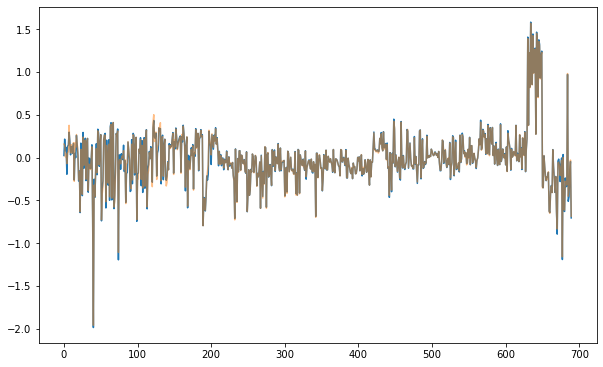

In [28]:
plt.plot(gamma_mode15[520][:690])
plt.plot(gamma_mode16[722][:690], alpha=0.5)
# plt.plot(gamma_mode15[520][:690])

In [22]:
# z score
B = A_B["B"]
A = A_B["A"]
A_prime = A_B["A_prime"]
# x = gamma_mode16[722]
x = gamma_mode15[520]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

4.640464057648172 4.608435332275099 21.38527852141851 5.906386491005833e-14


In [23]:
# z score
B = A_B["B"]
A = A_B["A"]
A_prime = A_B["A_prime"]
x = gamma_mode16[722][:690]
# x = gamma_mode15[520]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

4.5289848296963395 4.406746924004438 19.95808996712711 1.049871138799504


In [30]:
B = mode_15['B']
cutoff = 520
lamb, P = np.linalg.eig(B)
lamb, P = sort_eigenvalues_and_eigenvectors(lamb, P)
filtered_lamb = np.copy(lamb)
cutoff_mode = cutoff
filtered_B_inv, filtered_lamb, P = get_filtered_B_inv_lambda_and_P(filtered_lamb,
                                                                   cutoff_mode, P)
B_new = np.linalg.inv(filtered_B_inv)

In [75]:
from cvxopt import matrix, solvers
A_B = mode_15
# B = A_B['B']
B = B_new
A = A_B['A']
A_prime = A_B['A_prime']
n = len(A_prime)

Q = 2*matrix(B)
p = matrix(np.zeros(n))
# G = matrix(-A, (1,n))
# h = matrix(-7.117566, (1, 1), 'd')
additional_constraint = np.diag([-1]*n)
additional_constraint = A_B_6nq0_A['A_prime'].reshape(1,n)
additional_constraint = a_prime_all
# G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n), additional_constraint]), (2+n,n))
# h = matrix([-21, -0]+[15]*n, (2+n, 1), 'd')
# G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n), additional_constraint]), (2+1,n))
# h = matrix([-21, -0]+[-0], (2+1, 1), 'd')
n_additional_constraint = additional_constraint.shape[0]
G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n), additional_constraint]), (2+n_additional_constraint,n))
h = matrix([-21, -0]+[-0]*n_additional_constraint, (2+n_additional_constraint, 1), 'd')
sol=solvers.qp(Q, p, G=G, h=h)
x = np.array(sol['x']).flatten()

     pcost       dcost       gap    pres   dres
 0:  2.6911e+01  1.1442e+02  2e+04  1e+01  2e+05
 1:  5.8358e+01 -2.1890e+03  3e+03  2e+00  2e+04
 2:  3.4914e+01 -3.8051e+02  4e+02  2e-01  3e+03
 3:  2.7041e+01 -5.1661e+01  8e+01  4e-02  6e+02
 4:  2.5327e+01  5.3632e+00  2e+01  1e-02  1e+02
 5:  2.4482e+01  1.8007e+01  6e+00  3e-03  4e+01
 6:  2.4024e+01  2.0099e+01  4e+00  2e-03  2e+01
 7:  2.3816e+01  2.0166e+01  4e+00  1e-03  2e+01
 8:  2.3373e+01  2.1974e+01  1e+00  5e-04  7e+00
 9:  2.3148e+01  2.1622e+01  2e+00  4e-04  5e+00
10:  2.2864e+01  2.1785e+01  1e+00  2e-04  3e+00
11:  2.2550e+01  2.2311e+01  2e-01  5e-05  7e-01
12:  2.2519e+01  2.2515e+01  4e-03  4e-07  6e-03
13:  2.2519e+01  2.2519e+01  4e-05  4e-09  6e-05
14:  2.2519e+01  2.2519e+01  4e-07  4e-11  6e-07
15:  2.2519e+01  2.2519e+01  4e-09  5e-13  6e-09
Optimal solution found.


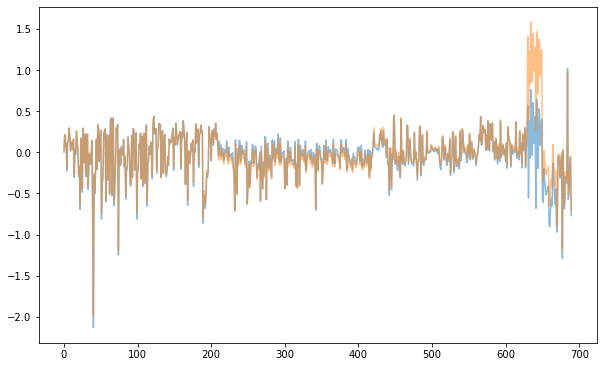

In [76]:
plt.plot(x, alpha=0.5)
plt.plot(gamma_mode15[520][:690], alpha=0.5)

In [73]:
# import glob
# ab_list = glob.glob("/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/optimization_msa_submode_15/A_B_dic/*.npy")
# a_prime_all = np.zeros((len(ab_list), 690))
# for abFile in ab_list:
#     A_B_one = np.load(abFile, allow_pickle=True).item()
#     a_prime_all = A_B_one["A_prime"]

abFile = "/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/optimization_msa_submode_15/a_prime_all.npy"
a_prime_all = np.load(abFile, allow_pickle=True)

In [74]:
a_prime_all

array([[1.87679006, 1.1369308 , 1.0812917 , ..., 1.23074547, 2.02222888,
        4.99261131],
       [4.85276668, 1.58350866, 1.40217948, ..., 1.84914302, 2.70250495,
        8.75344392],
       [0.9882021 , 0.60782271, 0.40400915, ..., 1.40091433, 1.79943992,
        3.7836284 ],
       ...,
       [0.39029175, 0.2278609 , 0.14997577, ..., 0.15530463, 0.06551744,
        0.62402178],
       [1.38424566, 1.25354991, 1.09497621, ..., 0.87404378, 1.34934104,
        2.70164878],
       [1.47953867, 0.79072309, 0.3829428 , ..., 1.34111058, 1.94186277,
        3.80409148]])

In [77]:
# z score
B = A_B["B"]
A = A_B["A"]
A_prime = A_B["A_prime"]
# x = gamma_mode16[722][:690]
# x = gamma_mode15[520]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

4.44948869404758 4.719643411633881 21.000000000001105 -66.08984543497455


In [78]:
np.savetxt("/Users/weilu/Research/server/oct_2020/membrane_protein_structure_prediction/gamma_folder/new_mode15_all_prime.dat", x)

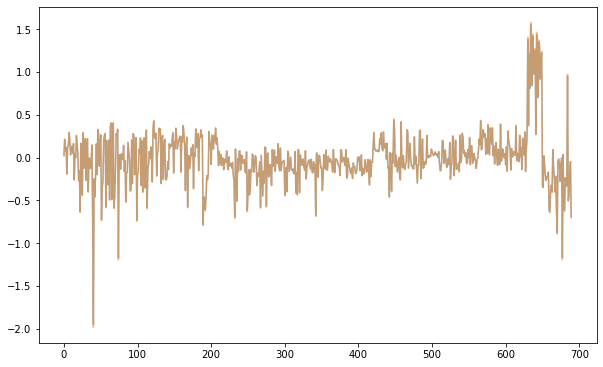

In [44]:
plt.plot(x, alpha=0.5)
plt.plot(gamma_mode15[520][:690], alpha=0.5)

In [4]:
pre = "/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/optimization_msa_submode_16/gamma/"
mode_16 = get_A_B(pre, n=2022)

In [5]:
A_B = mode_16
cutoff_range=list(range(522, 2122, 100)) 
gamma_mode16 = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-0, cutoff_range=cutoff_range)

In [8]:
# z score
B = A_B["B"]
A = A_B["A"]
A_prime = A_B["A_prime"]
x = gamma_mode16[722]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

5.006197747326388 4.816455992909468 24.11213114180006 2.372545519421787e-13


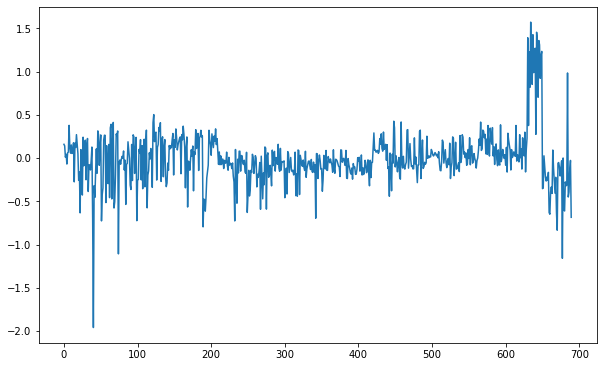

In [6]:
plt.plot(gamma_mode16[722][:690])

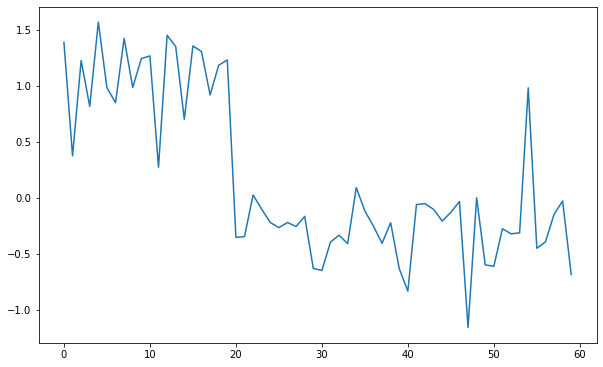

In [9]:
plt.plot(gamma_mode16[722][630:690])

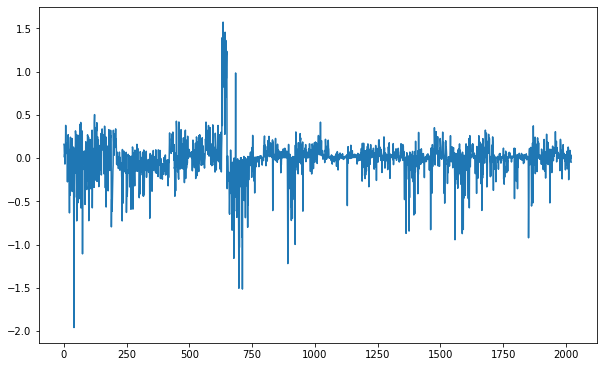

In [7]:
plt.plot(gamma_mode16[722])

In [10]:
toLocation = "/Users/weilu/Research/server/oct_2020/membrane_protein_structure_prediction/gamma_folder"
np.savetxt(f"{toLocation}/complete_cutoff722_contact_part_oct11.dat", x[:690])
np.savetxt(f"{toLocation}/complete_cutoff722_fourBody_part_oct11.dat", -x[690:])
np.savetxt(f"{toLocation}/complete_cutoff722_all_part_oct11.dat", x)

In [12]:
A_B["A_prime"].dot(gamma_mode16[722])

2.372545519421787e-13

## weighted differently

In [265]:
pre = "/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/optimization_msa_submode_20/with_weighted_gamma/"
mode_20_weighted = get_A_B(pre, n=690)

In [266]:
A_B = mode_20_weighted
cutoff_range=list(range(400, 700, 20)) 
gamma_mode_20_weighted = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-100, cutoff_range=cutoff_range)

In [267]:
# z score
A_B = mode_20_weighted
B = A_B["B"]
A = A_B["A"]
A_prime = A_B["A_prime"]
# x = gamma_mode16[722]
x = gamma_mode_20_weighted[600]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

1.3131035441155132 1.766509739058924 2.3196101990728435 -100.00000000000004


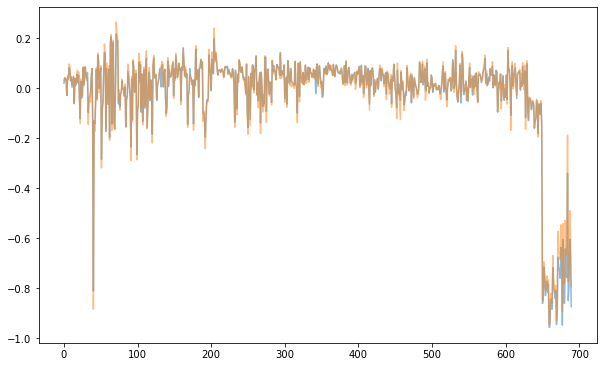

In [268]:
plt.plot(gamma_mode20[600][:690], alpha=0.5)
plt.plot(gamma_mode_20_weighted[600][:690], alpha=0.5)